In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pandas as pd
import networkx as nx
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import numpy as np  
from earlystopping import EarlyStopping
from torch.nn import functional as F
import dgl.function as fn
from models import *
from utils import *

Using backend: pytorch


In [2]:
#cerevisiae,silico,coli
name='cerevisiae'
expression,network,tfs=load_data_new(name)

In [3]:
neg_sub_index=2

In [4]:
scaler = MinMaxScaler()
data=scaler.fit_transform(expression).T
# def max_scale(X):
#     return X/X.max(axis=1).reshape(-1,1)   
# data=max_scale(expression.values.T)

In [5]:
# adj_l,adj_m,adj_row=adj_list(data,min_k=1,metric='pearson',dr=False)

In [6]:
# a,b=data[np.array(adj_l)[:,0]],data[np.array(adj_l)[:,1]]

In [7]:
# corr1_data=np.concatenate((a,b),axis=1)

In [8]:
df_expression=pd.DataFrame(data.T, columns=expression.columns)
# df_expression=expression

In [9]:
src_gene=network[0].values
dst_gene=network[1].values

In [10]:
src_expression_df=df_expression[src_gene]
dst_expression_df=df_expression[dst_gene]

In [11]:
input_x=torch.tensor(src_expression_df.T.values,dtype=torch.float32)
input_y=torch.tensor(dst_expression_df.T.values,dtype=torch.float32)

In [12]:
# inputs=torch.cat([input_x,input_y],1)

In [13]:
# scaler2 = MinMaxScaler()
# data1=scaler2.fit_transform(inputs.T).T

In [14]:
# inputs=torch.tensor(data,dtype=torch.float32)

In [15]:
inputs=torch.cat([input_x,input_y],1)
# inputs=np.hstack((input_x,input_y)).reshape(input_x.shape[0],2,input_x.shape[1])

In [16]:
# inputs=torch.tensor(inputs,dtype=torch.float32)

In [17]:
class fusion1(nn.Module):
    def __init__(self, infeats,hid_feat,out_feat, reduction=16):
        super(fusion1, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(infeats*2, infeats*2 // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(infeats*2 // reduction, infeats, bias=False),
            nn.Sigmoid()
        )
        self.fc1=nn.Linear(infeats*2, infeats*2 // reduction, bias=False)
        self.fc2= nn.Linear(infeats*2 // reduction, infeats, bias=False)
        self.fc3= nn.Linear(infeats*2 // reduction, infeats, bias=False)
        self.x_layer=nn.Linear(in_feats,in_feats*2)
        self.y_layer=nn.Linear(in_feats,in_feats*2)
        self.mlp=nn.Sequential(
            nn.Linear(in_feats*2, hid_feat),
            nn.ReLU(inplace=True),
            nn.Linear(hid_feat, hid_feat),
            nn.ReLU(inplace=True),
            nn.Linear(hid_feat, out_feat)            
        )
        self.sig=nn.Sigmoid()
    def Norm(self,inp):
        return (inp-inp.mean(axis=1).view(-1,1))/inp.std(axis=1).view(-1,1)  
    
    def forward(self, x,y,inputs):
        
#         xy=self.fc(inputs)
#         xyl=torch.cat([x*xy,y*xy],1)
#         xy=xy*inputs
#         xy=self.sig(xy)
        xy1=self.fc1(inputs)
        xy1=F.relu(xy1)
        xy2=self.fc2(xy1)
        xy3=self.fc3(xy1)
        xy2=self.sig(xy2)
        xy3=self.sig(xy3)
        xl=self.Norm(x*xy2)
        yl=self.Norm(y*xy3)
#         xyl=self.Norm(xyl)
        xyl=torch.cat([xl,yl],1)
#         xyl=inputs*xy
#         xyl=self.Norm(xyl)
        xyl=self.mlp(xyl)
        
        return torch.sigmoid(xyl)
# #         b, c, _, _ = x.size()
# #         y = self.avg_pool(x).view(b, c)
# #         y = self.fc(y).view(b, c, 1, 1)
# #         return x * y.expand_as(x)

In [18]:
# class fusion2(nn.Module):
#     def __init__(self, infeats,hid_feat,out_feat, reduction=16):
#         super(fusion2, self).__init__()
# #         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Linear(infeats*2, infeats*2 // reduction, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Linear(infeats*2 // reduction, infeats*2, bias=False),
#             nn.Sigmoid()
#         )
#         self.xy_layer=nn.Linear(in_feats*2,in_feats)
#         self.y_layer=nn.Linear(in_feats,in_feats*2)
#         self.mlp=nn.Sequential(
#             nn.Linear(in_feats*2, hid_feat),
#             nn.ReLU(inplace=True),
#             nn.Linear(hid_feat, hid_feat),
#             nn.ReLU(inplace=True),
#             nn.Linear(hid_feat, out_feat)            
#         )
#         self.sig=nn.Sigmoid()
#     def Norm(self,inp):
#         return (inp-inp.mean(axis=1).view(-1,1))/inp.std(axis=1).view(-1,1)  
    
#     def forward(self, x,y,inputs):
        
#         xy=self.fc(inputs)
# #         xyl=torch.cat([x*xy,y*xy],1)
# #         xy=xy*inputs
# #         xy=self.sig(xy)
# #         xy=
#         xy=self.sig(self.xy_layer(self.Norm(inputs*xy)))
        
#         xl=self.Norm(x*xy)
#         yl=self.Norm(y*xy)
# #         xyl=self.Norm(xyl)
#         xyl=torch.cat([xl,yl],1)
# #         xyl=inputs*xy
# #         xyl=self.Norm(xyl)
#         xyl=self.mlp(xyl)
        
#         return torch.sigmoid(xyl)
# # #         b, c, _, _ = x.size()
# # #         y = self.avg_pool(x).view(b, c)
# # #         y = self.fc(y).view(b, c, 1, 1)
# # #         return x * y.expand_as(x)

In [19]:
# class fusion3(nn.Module):
#     def __init__(self, infeats,hid_feat,out_feat, reduction=16):
#         super(fusion3, self).__init__()
# #         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Linear(infeats, infeats // reduction, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Linear(infeats // reduction, infeats, bias=False),
#             nn.Sigmoid()
#         )
#         self.xy_layer=nn.Linear(in_feats*2,in_feats)
#         self.y_layer=nn.Linear(in_feats,in_feats*2)
#         self.mlp=nn.Sequential(
#             nn.Linear(in_feats*2, hid_feat),
#             nn.ReLU(inplace=True),
#             nn.Linear(hid_feat, hid_feat),
#             nn.ReLU(inplace=True),
#             nn.Linear(hid_feat, out_feat)            
#         )
#         self.sig=nn.Sigmoid()
#     def Norm(self,inp):
#         return (inp-inp.mean(axis=1).view(-1,1))/inp.std(axis=1).view(-1,1)  
    
#     def forward(self, x,y,inputs):
#         residual_x=x
#         residual_y=y
        
#         out_x=self.fc(x)
#         out_y=self.fc(y)
        
#         out_x=self.Norm(residual_x*out_x)
#         out_y=self.Norm(residual_y*out_y)
        
#         xy=torch.cat([out_x,out_y],1)
        
# #         xy=self.fc(inputs)
# # #         xyl=torch.cat([x*xy,y*xy],1)
# # #         xy=xy*inputs
# # #         xy=self.sig(xy)
# # #         xy=
# #         xy=self.sig(self.xy_layer(self.Norm(inputs*xy)))
        
# #         xl=self.Norm(x*xy)
# #         yl=self.Norm(y*xy)
# # #         xyl=self.Norm(xyl)
# #         xyl=torch.cat([xl,yl],1)
# # #         xyl=inputs*xy
# # #         xyl=self.Norm(xyl)
#         xyl=self.mlp(xy)
        
#         return torch.sigmoid(xyl)
# # #         b, c, _, _ = x.size()
# # #         y = self.avg_pool(x).view(b, c)
# # #         y = self.fc(y).view(b, c, 1, 1)
# # #         return x * y.expand_as(x)

In [20]:
# class fusion4(nn.Module):
#     def __init__(self, infeats,hid_feat,out_feat, reduction=16):
#         super(fusion4, self).__init__()
# #         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Linear(infeats, infeats // reduction, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Linear(infeats // reduction, infeats, bias=False),
#             nn.Sigmoid()
#         )
    
#         self.fc2 = nn.Sequential(
#             nn.Linear(infeats*2, infeats*2 // reduction*2, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Linear(infeats*2 // reduction*2, infeats*2, bias=False),
#             nn.Sigmoid()
#         )
#         self.xy_layer=nn.Linear(in_feats*2,in_feats)
#         self.y_layer=nn.Linear(in_feats,in_feats*2)
#         self.mlp=nn.Sequential(
#             nn.Linear(in_feats*2, hid_feat),
#             nn.ReLU(inplace=True),
#             nn.Linear(hid_feat, hid_feat),
#             nn.ReLU(inplace=True),
#             nn.Linear(hid_feat, out_feat)            
#         )
#         self.sig=nn.Sigmoid()
#     def Norm(self,inp):
#         return (inp-inp.mean(axis=1).view(-1,1))/inp.std(axis=1).view(-1,1)  
    
#     def forward(self, x,y,inputs):
#         residual_x=x
#         residual_y=y
        
#         out_x=self.fc(x)
#         out_y=self.fc(y)
        
#         out_x=self.Norm(residual_x*out_x)
#         out_y=self.Norm(residual_y*out_y)
        
#         xy=torch.cat([out_x,out_y],1)
        
#         xy_fc=self.fc2(xy)
#         xy_m=xy_fc*inputs
#         xy_m=self.Norm(xy_m)
        
# #         xy=self.fc(inputs)
# # #         xyl=torch.cat([x*xy,y*xy],1)
# # #         xy=xy*inputs
# # #         xy=self.sig(xy)
# # #         xy=
# #         xy=self.sig(self.xy_layer(self.Norm(inputs*xy)))
        
# #         xl=self.Norm(x*xy)
# #         yl=self.Norm(y*xy)
# # #         xyl=self.Norm(xyl)
# #         xyl=torch.cat([xl,yl],1)
# # #         xyl=inputs*xy
# # #         xyl=self.Norm(xyl)
#         xyl=self.mlp(xy_m)
        
#         return torch.sigmoid(xyl)
# # #         b, c, _, _ = x.size()
# # #         y = self.avg_pool(x).view(b, c)
# # #         y = self.fc(y).view(b, c, 1, 1)
# # #         return x * y.expand_as(x)

In [21]:
pos_number=network[network[4]==1].shape[0]
negtive_number=network[network[4]==0].shape[0]

In [22]:
test_ratio=0.1
val_ratio=0.1

In [23]:
pos_maks_result= pos_masks(pos_number,negtive_number, test_ratio)

In [24]:
train_pos_mask=pos_maks_result['pos_masks'][0]
test_pos_mask=pos_maks_result['pos_masks'][1]
val_pos_mask=pos_maks_result['pos_masks'][2]

In [25]:
test_pos_id=pos_maks_result['test_id']

In [26]:
test_neg_mask,val_neg_mask,train_neg_set=test_val_neg_maks(pos_number,negtive_number,test_ratio,val_ratio)

In [27]:
def train_neg_mask_build(pos_number,negtive_number,train_neg_set,train_size):
#     train_size = pos_number - (test_ratio+val_ratio)
    train_neg_id=np.random.permutation(train_neg_set)
    train_neg_id=train_neg_id[:train_size]
    
    train_neg_mask=np.full((pos_number+negtive_number), False)
    train_neg_mask[train_neg_id]=True    
    
    return train_neg_mask

In [28]:
# train_neg_set=np.random.permutation(train_neg_set)

In [29]:
# neg_sets==np.array_split(train_neg_set,3)
# neg_sets=train_neg_set

In [30]:

# train_neg_set=neg_sets[neg_sub_index]

In [31]:
# val_neg_test=train_neg_set[:int(pos_number*val_ratio)]

In [32]:
# train_neg_set=train_neg_set[int(pos_number*val_ratio):]

In [33]:
# val_neg_mask=np.full((pos_number+negtive_number), False)
# val_neg_mask[val_neg_test]=True

In [34]:
train_size = pos_maks_result['train_size']
# train_neg_mask=train_neg_mask_build(pos_number,negtive_number,train_neg_set,train_size)

In [35]:
lr=0.001
weight_decay=0.
in_feats=input_x.shape[1]
n_hidden=128
out_dim=1
# n_layers=1
# norm=None
# activation=F.relu
# dropout=0.
# aggregator_type='pool'

In [36]:
model=fusion1(in_feats,n_hidden,out_dim)

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)

In [38]:
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [39]:
patience = 20
early_stopping = EarlyStopping(patience,path='conv.pt', verbose=True) 

In [40]:
for epoch in range(1000000):
    model.train()
    
    train_neg_mask=train_neg_mask_build(pos_number,negtive_number,train_neg_set,train_size)
    
    logits = model(input_x,input_y,inputs)
#     loss,train_acc = compute_loss(logits[train_pos_mask],logits[train_neg_mask])
    loss= binary_loss(logits[train_pos_mask].view(-1),logits[train_neg_mask].view(-1))
    
    val_loss,acc = binary_val3(model,input_x,input_y,inputs,val_pos_mask,val_neg_mask)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#     scheduler.step()
    if epoch % 5 == 0:
        print('In epoch {}, train_loss: {},val_loss:{},val_acc:{}'.format(epoch, loss,val_loss,acc))
#         print('In epoch {}, train_loss: {}, train_acc:{},val_loss:{},val_acc:{}'.format(epoch, loss,train_acc,val_loss,acc))
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print  ("Early stopping")
        break 
with torch.no_grad():
#     model.load_state_dict(torch.load('dot_dnn.pt')) 
    pred = model(input_x,input_y,inputs)
#     test_loss, test_acc=compute_loss(pred[test_pos_mask],pred[test_neg_mask])
    test_loss=binary_loss(pred[test_pos_mask].view(-1),pred[test_neg_mask].view(-1))
    test_acc=compute_auc(pred[test_pos_mask].view(-1),pred[test_neg_mask].view(-1))
    print(test_loss)
    print(test_acc)

In epoch 0, train_loss: 0.6914793848991394,val_loss:0.6926318407058716,val_acc:0.5271715323765106
In epoch 5, train_loss: 0.6342646479606628,val_loss:0.6226556897163391,val_acc:0.7292509469452962
In epoch 10, train_loss: 0.6004579663276672,val_loss:0.5817379355430603,val_acc:0.7730874281738773
In epoch 15, train_loss: 0.5710968375205994,val_loss:0.5449512004852295,val_acc:0.8154422943131747
In epoch 20, train_loss: 0.5428081750869751,val_loss:0.515661358833313,val_acc:0.8335888582545286
In epoch 25, train_loss: 0.5183410048484802,val_loss:0.5003213882446289,val_acc:0.8409067484346414
In epoch 30, train_loss: 0.49506819248199463,val_loss:0.48694103956222534,val_acc:0.8492939782009328
In epoch 35, train_loss: 0.4684229791164398,val_loss:0.4806852638721466,val_acc:0.8501765054497668
In epoch 40, train_loss: 0.4379933178424835,val_loss:0.4739850163459778,val_acc:0.8542734932618723
In epoch 45, train_loss: 0.4236830174922943,val_loss:0.46593567728996277,val_acc:0.8590404287665232
In epoch 5

In [41]:

# with torch.no_grad():
#     model.load_state_dict(torch.load('conv.pt')) 
#     pred = model(input_x,input_y,inputs)
# #     test_loss, test_acc=compute_loss(pred[test_pos_mask],pred[test_neg_mask])
#     test_loss=binary_loss(pred[test_pos_mask].view(-1),pred[test_neg_mask].view(-1))
#     test_acc=compute_auc(pred[test_pos_mask].view(-1),pred[test_neg_mask].view(-1))
#     print(test_loss)
#     print(test_acc)

In [42]:
from sklearn.metrics import precision_recall_curve

In [43]:
with torch.no_grad():
#     model.load_state_dict(torch.load('dot_dnn.pt')) 
    pred = model(input_x,input_y,inputs)
#     test_loss, test_acc=compute_loss(pred[test_pos_mask],pred[test_neg_mask])
    pos_logits,neg_logits=pred[test_pos_mask].view(-1),pred[test_neg_mask].view(-1)
    pre = torch.cat([pos_logits, neg_logits])
    labels = torch.cat([torch.ones(pos_logits.shape[0]), torch.zeros(neg_logits.shape[0])])
    
    precision, recall, thresholds = precision_recall_curve(labels, pre)

In [44]:
precision

array([0.50063532, 0.5       , 0.50063694, 0.50127551, 0.50191571,
       0.50255754, 0.50320102, 0.50384615, 0.50449294, 0.50514139,
       0.50579151, 0.5064433 , 0.50709677, 0.50775194, 0.5084088 ,
       0.50906736, 0.50972763, 0.51038961, 0.51105332, 0.51171875,
       0.51238592, 0.51305483, 0.5124183 , 0.5117801 , 0.51245085,
       0.51312336, 0.51379763, 0.51447368, 0.51515152, 0.51583113,
       0.51651255, 0.51719577, 0.51655629, 0.51724138, 0.51792829,
       0.51861702, 0.51930759, 0.52      , 0.52069426, 0.52139037,
       0.52208835, 0.5227882 , 0.52214765, 0.52284946, 0.52355316,
       0.52425876, 0.52496626, 0.52567568, 0.52638701, 0.52710027,
       0.52781547, 0.52853261, 0.5292517 , 0.52997275, 0.53069577,
       0.53142077, 0.53214774, 0.53287671, 0.53360768, 0.53434066,
       0.53507565, 0.53581267, 0.53655172, 0.53729282, 0.53803596,
       0.53878116, 0.53952843, 0.54027778, 0.54102921, 0.54178273,
       0.54253835, 0.54329609, 0.54405594, 0.54481793, 0.54558

In [45]:
recall

array([1.        , 0.99746193, 0.99746193, 0.99746193, 0.99746193,
       0.99746193, 0.99746193, 0.99746193, 0.99746193, 0.99746193,
       0.99746193, 0.99746193, 0.99746193, 0.99746193, 0.99746193,
       0.99746193, 0.99746193, 0.99746193, 0.99746193, 0.99746193,
       0.99746193, 0.99746193, 0.99492386, 0.99238579, 0.99238579,
       0.99238579, 0.99238579, 0.99238579, 0.99238579, 0.99238579,
       0.99238579, 0.99238579, 0.98984772, 0.98984772, 0.98984772,
       0.98984772, 0.98984772, 0.98984772, 0.98984772, 0.98984772,
       0.98984772, 0.98984772, 0.98730964, 0.98730964, 0.98730964,
       0.98730964, 0.98730964, 0.98730964, 0.98730964, 0.98730964,
       0.98730964, 0.98730964, 0.98730964, 0.98730964, 0.98730964,
       0.98730964, 0.98730964, 0.98730964, 0.98730964, 0.98730964,
       0.98730964, 0.98730964, 0.98730964, 0.98730964, 0.98730964,
       0.98730964, 0.98730964, 0.98730964, 0.98730964, 0.98730964,
       0.98730964, 0.98730964, 0.98730964, 0.98730964, 0.98730

In [46]:
pos_logits,neg_logits=pred[test_pos_mask].view(-1),pred[test_neg_mask].view(-1)
pre = torch.cat([pos_logits, neg_logits])
labels = torch.cat([torch.ones(pos_logits.shape[0]), torch.zeros(neg_logits.shape[0])])

In [47]:

precision, recall, thresholds = precision_recall_curve(labels, pre)

In [48]:
recall.shape

(788,)

In [49]:
precision

array([0.50063532, 0.5       , 0.50063694, 0.50127551, 0.50191571,
       0.50255754, 0.50320102, 0.50384615, 0.50449294, 0.50514139,
       0.50579151, 0.5064433 , 0.50709677, 0.50775194, 0.5084088 ,
       0.50906736, 0.50972763, 0.51038961, 0.51105332, 0.51171875,
       0.51238592, 0.51305483, 0.5124183 , 0.5117801 , 0.51245085,
       0.51312336, 0.51379763, 0.51447368, 0.51515152, 0.51583113,
       0.51651255, 0.51719577, 0.51655629, 0.51724138, 0.51792829,
       0.51861702, 0.51930759, 0.52      , 0.52069426, 0.52139037,
       0.52208835, 0.5227882 , 0.52214765, 0.52284946, 0.52355316,
       0.52425876, 0.52496626, 0.52567568, 0.52638701, 0.52710027,
       0.52781547, 0.52853261, 0.5292517 , 0.52997275, 0.53069577,
       0.53142077, 0.53214774, 0.53287671, 0.53360768, 0.53434066,
       0.53507565, 0.53581267, 0.53655172, 0.53729282, 0.53803596,
       0.53878116, 0.53952843, 0.54027778, 0.54102921, 0.54178273,
       0.54253835, 0.54329609, 0.54405594, 0.54481793, 0.54558

In [50]:
from sklearn.metrics import PrecisionRecallDisplay

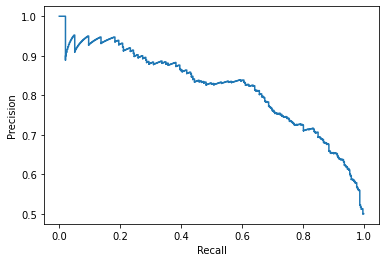

In [51]:
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()

In [52]:
ptname=name+'_attff_'+str(neg_sub_index)
torch.save(model, ptname+'.pkl')

In [53]:
0.83/0.84/0.836

1.1819321029847347

In [54]:
0.9689178998963144

0.9689178998963144